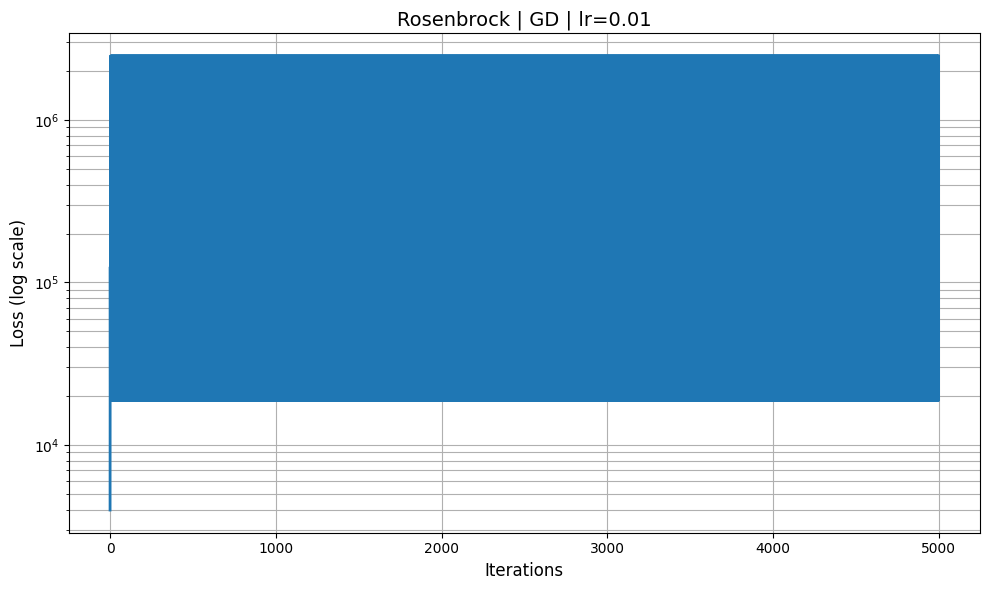

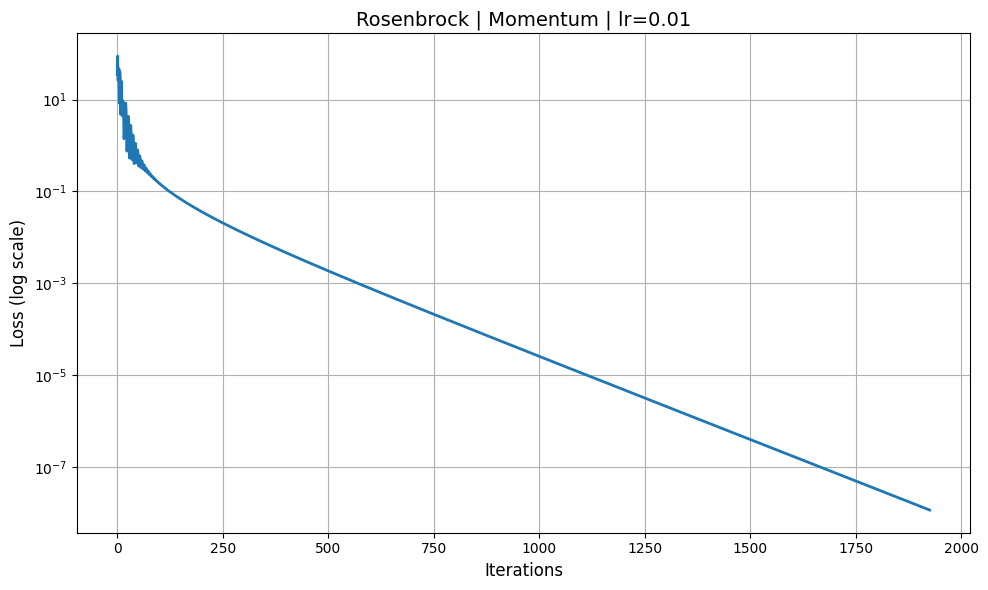

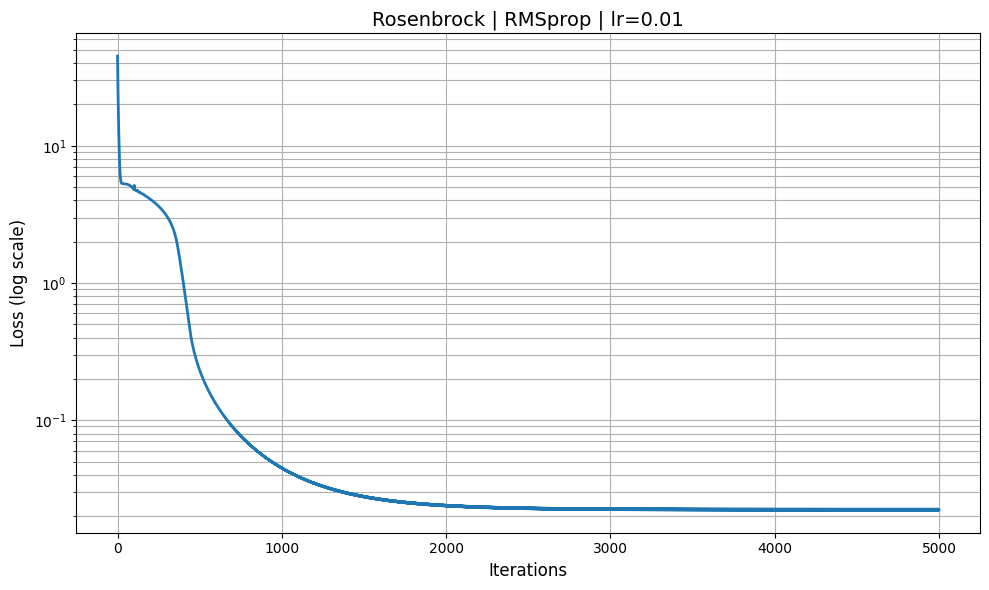

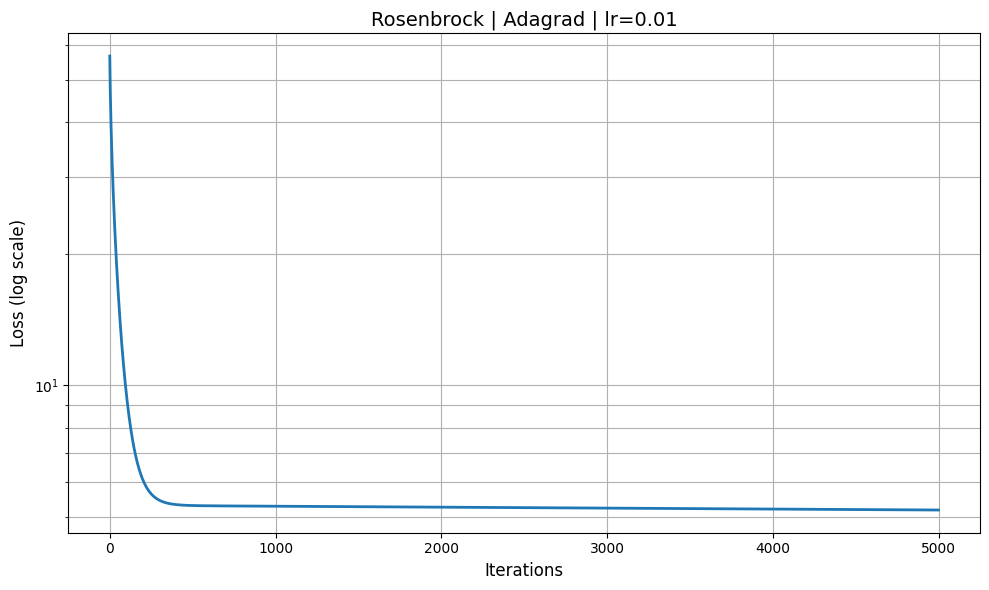

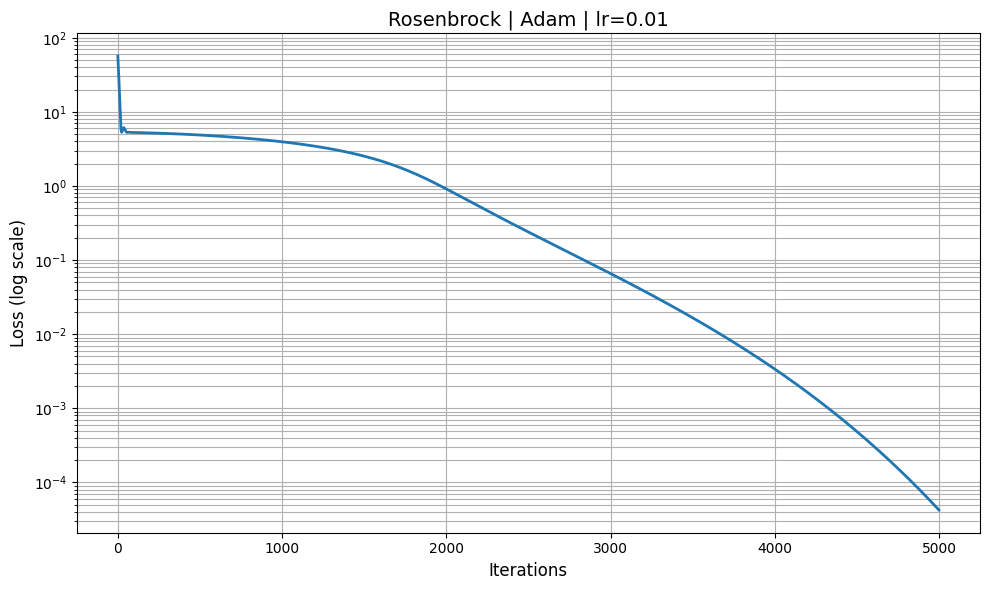

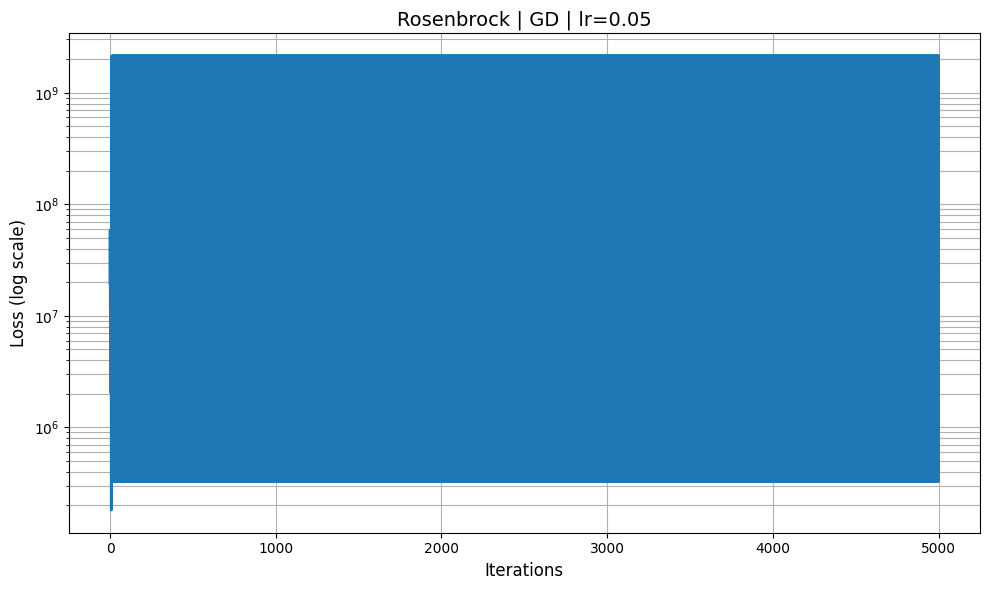

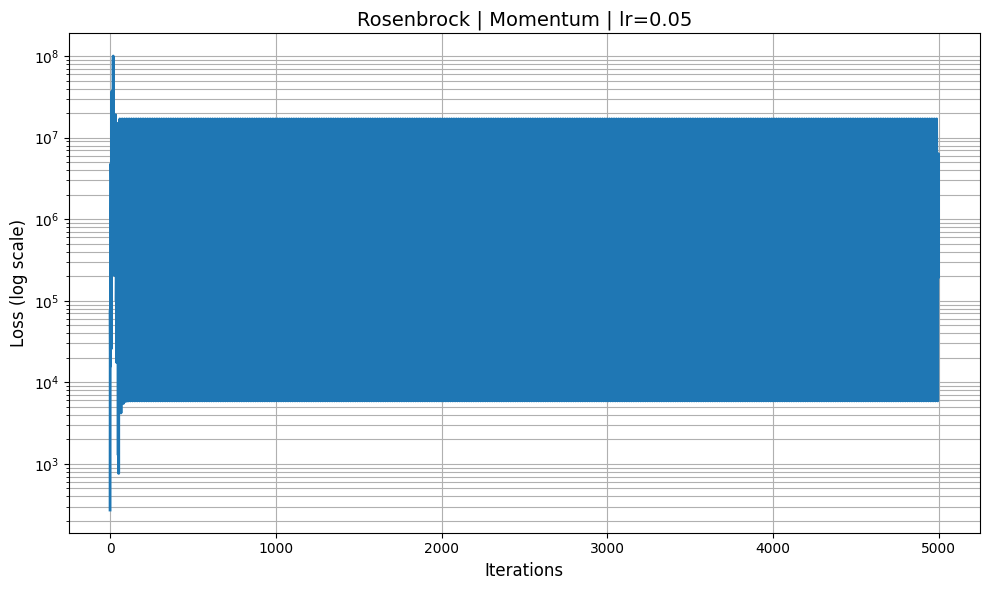

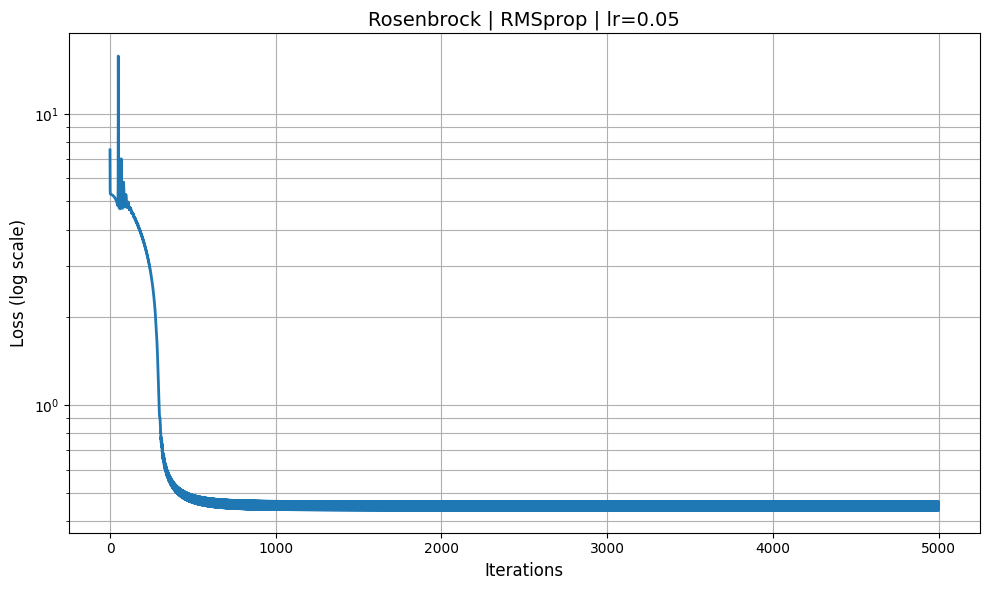

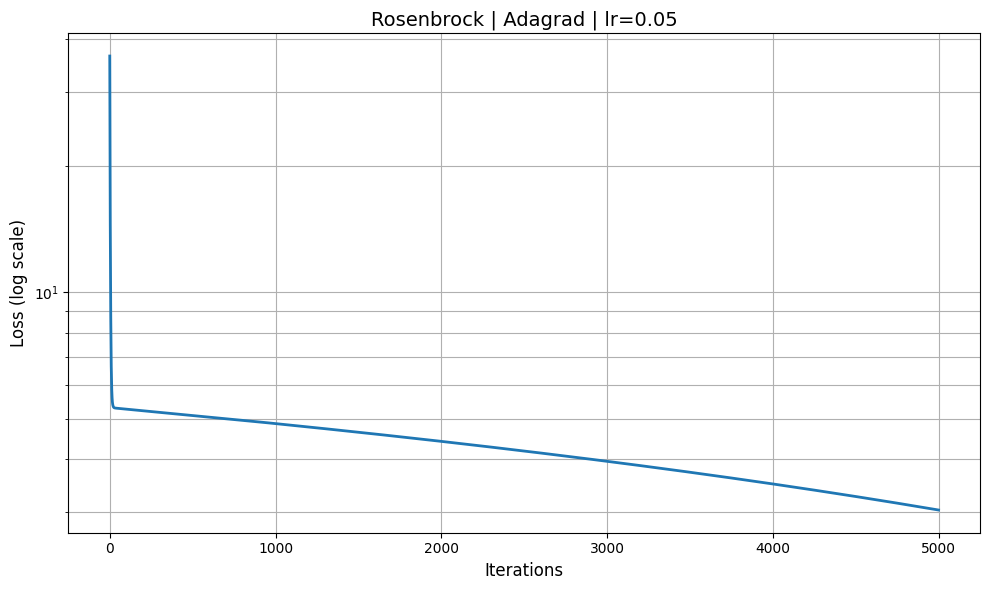

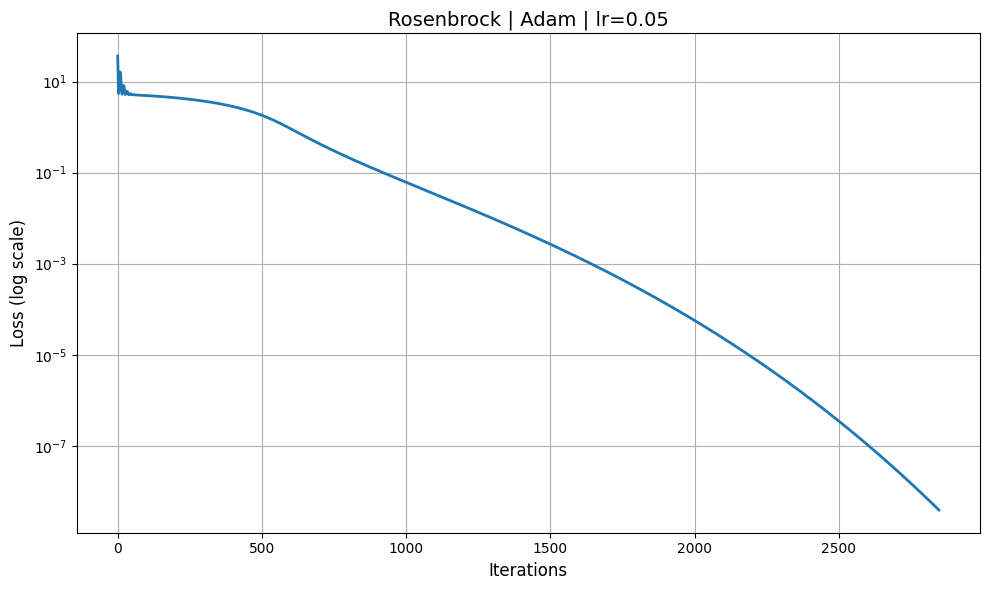

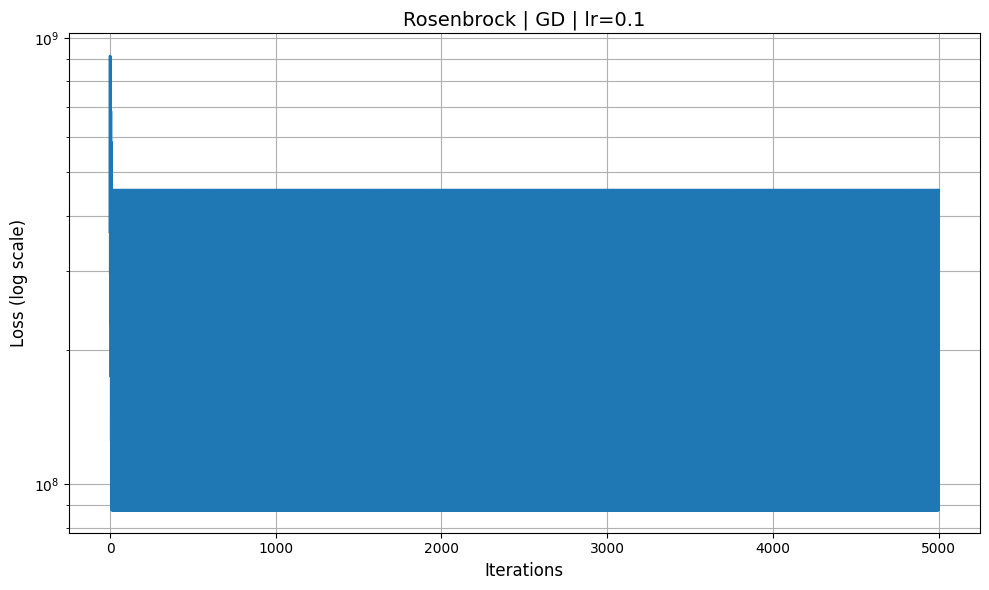

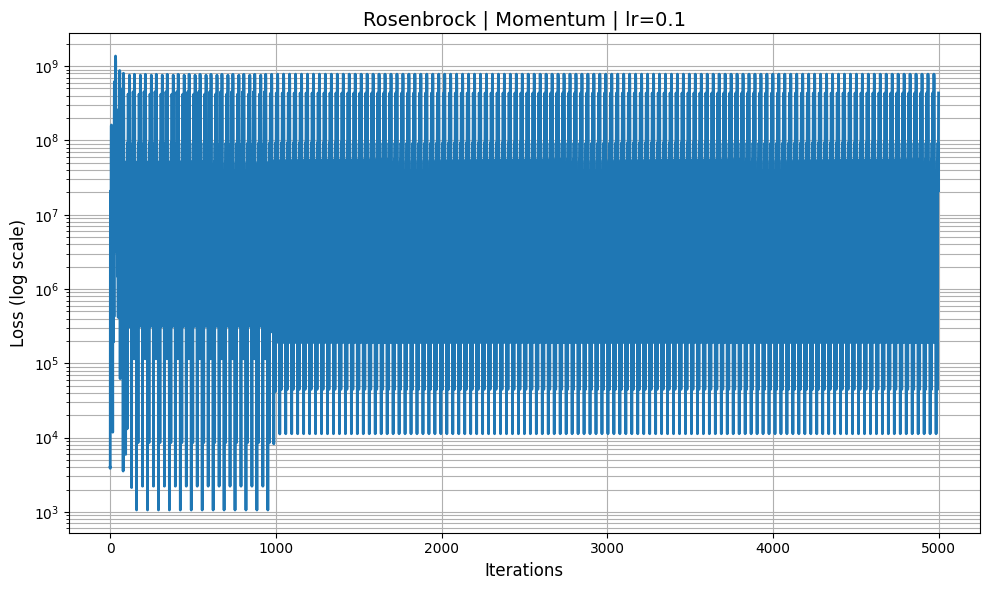

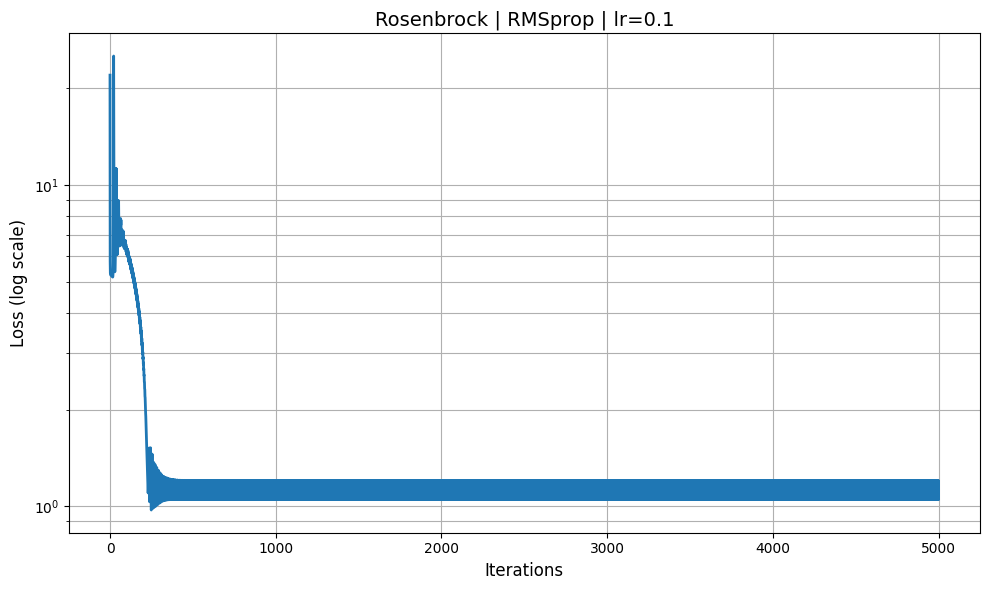

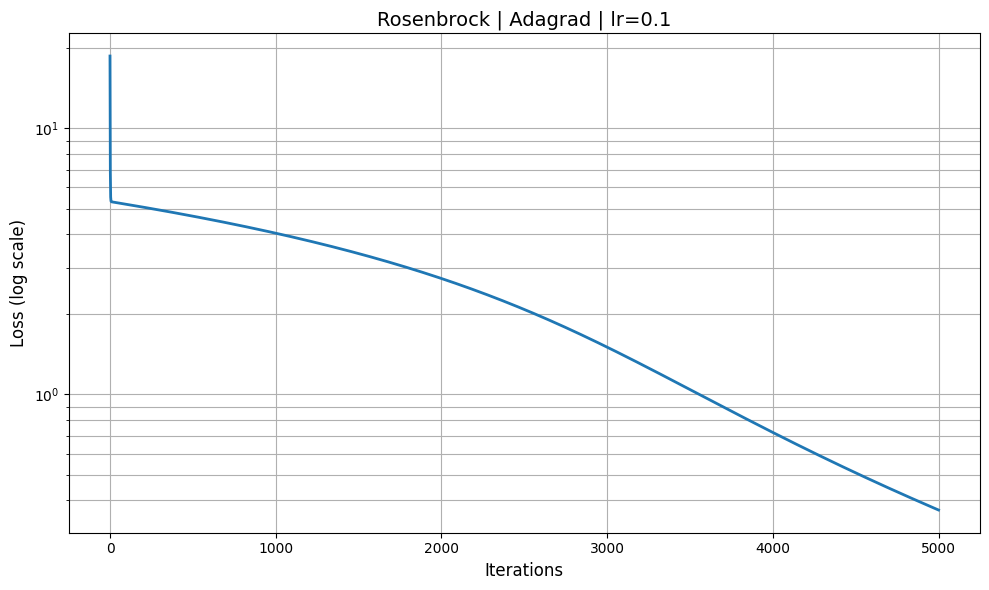

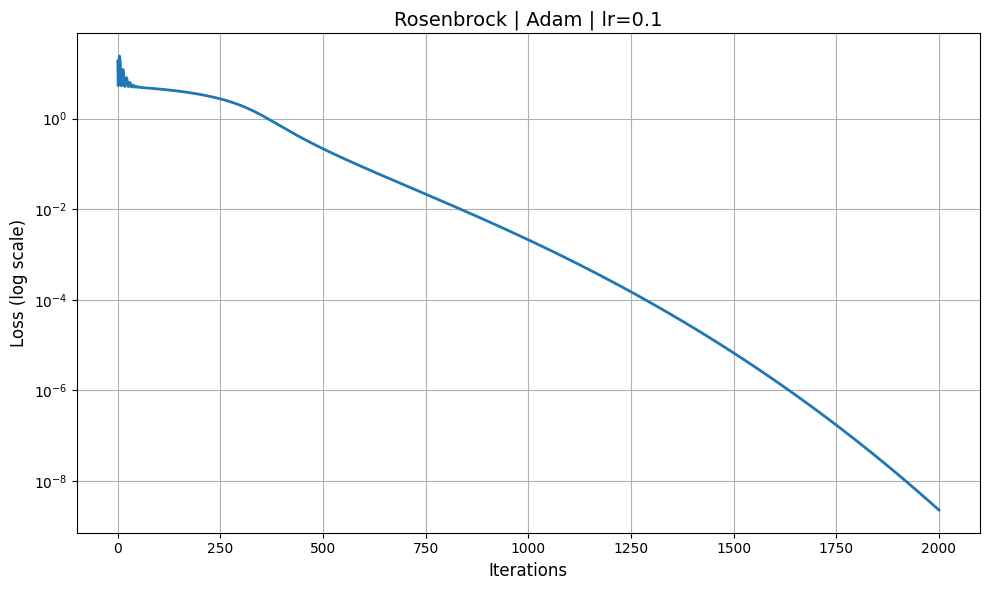

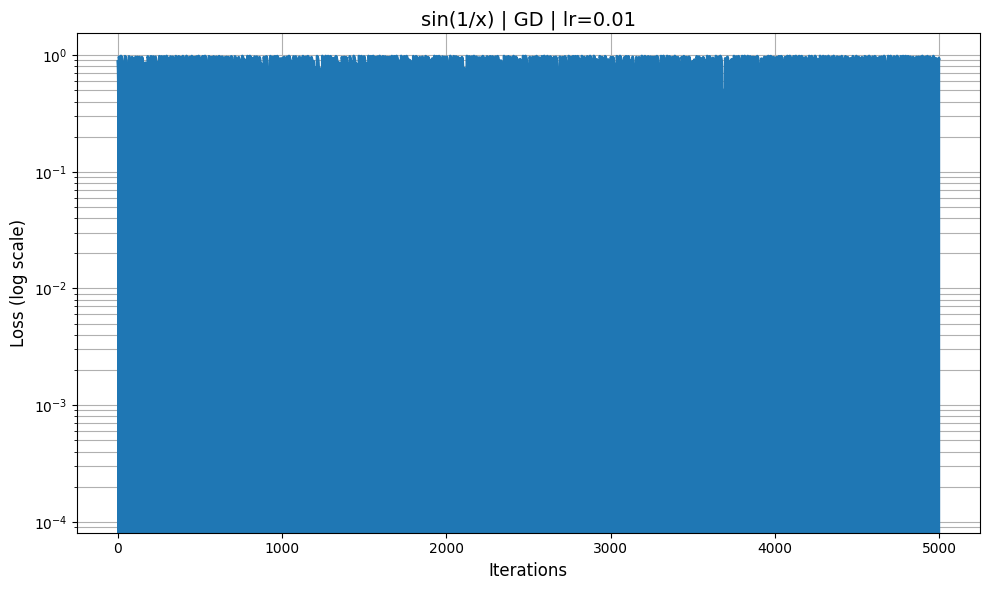

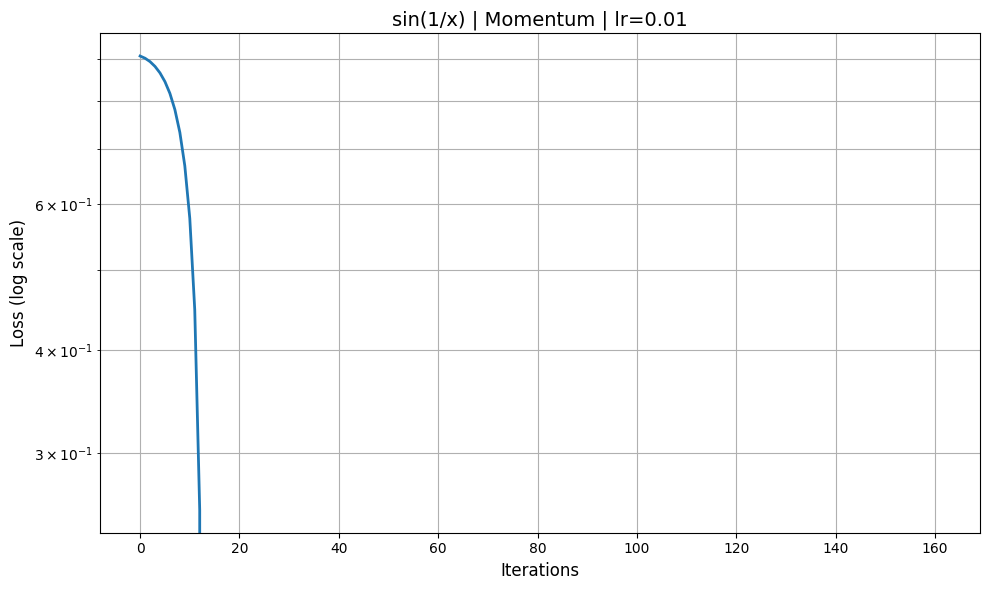

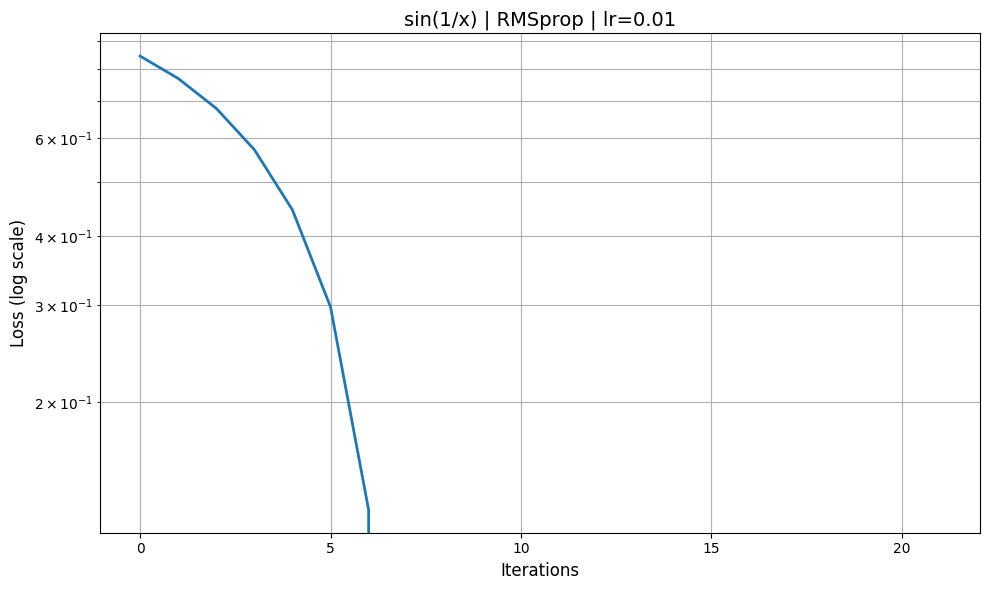

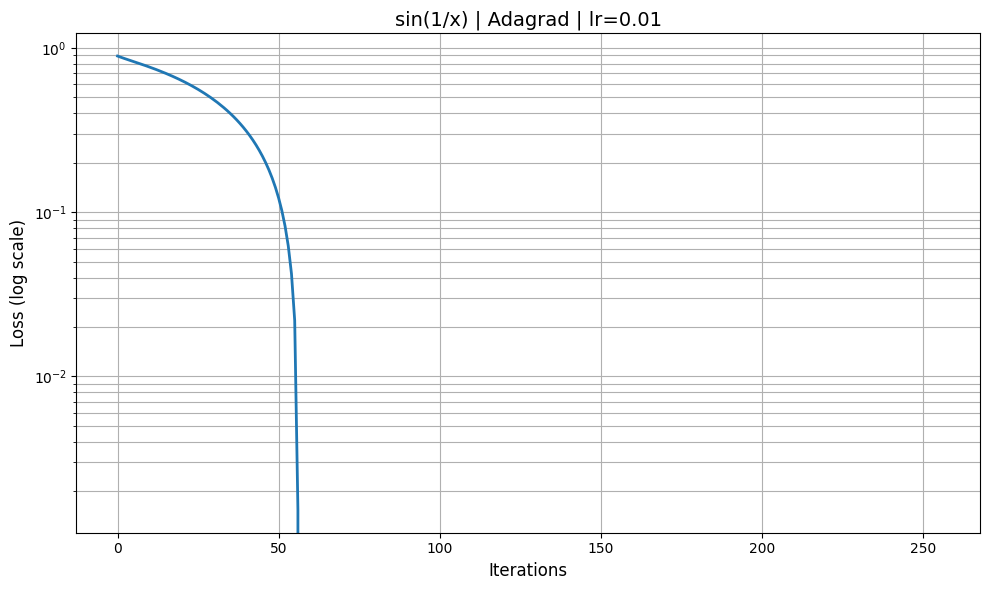

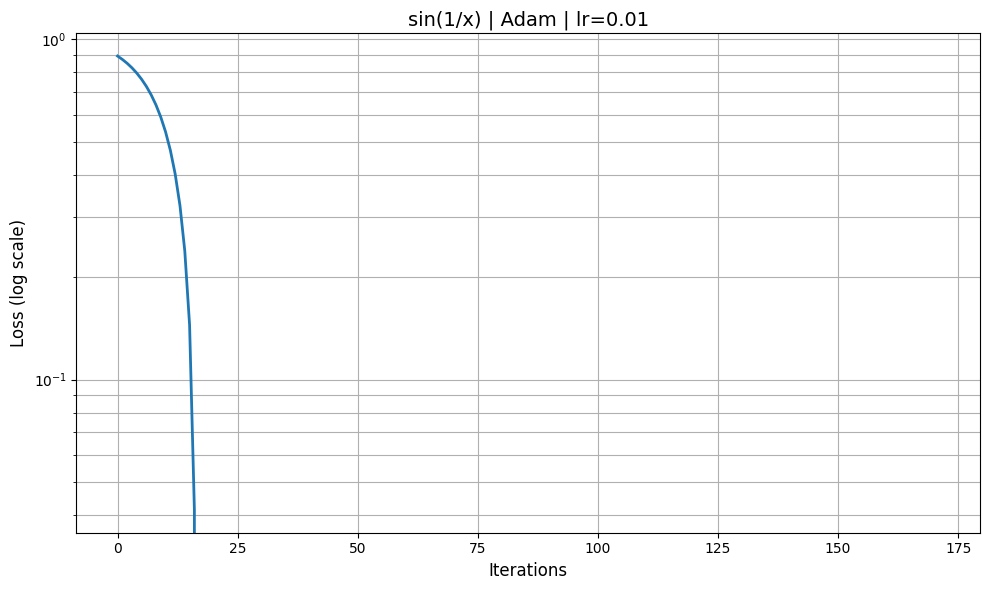

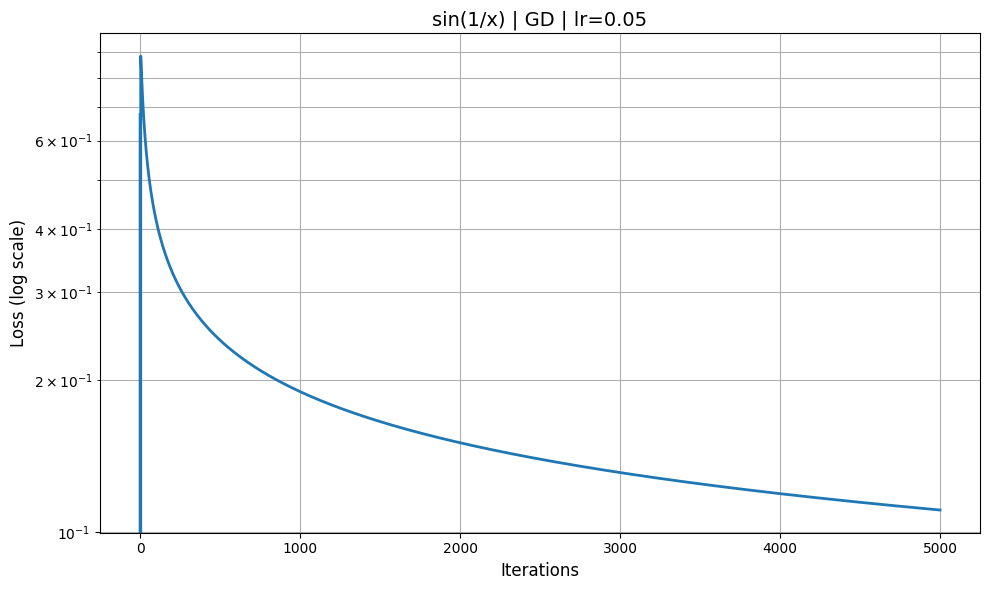

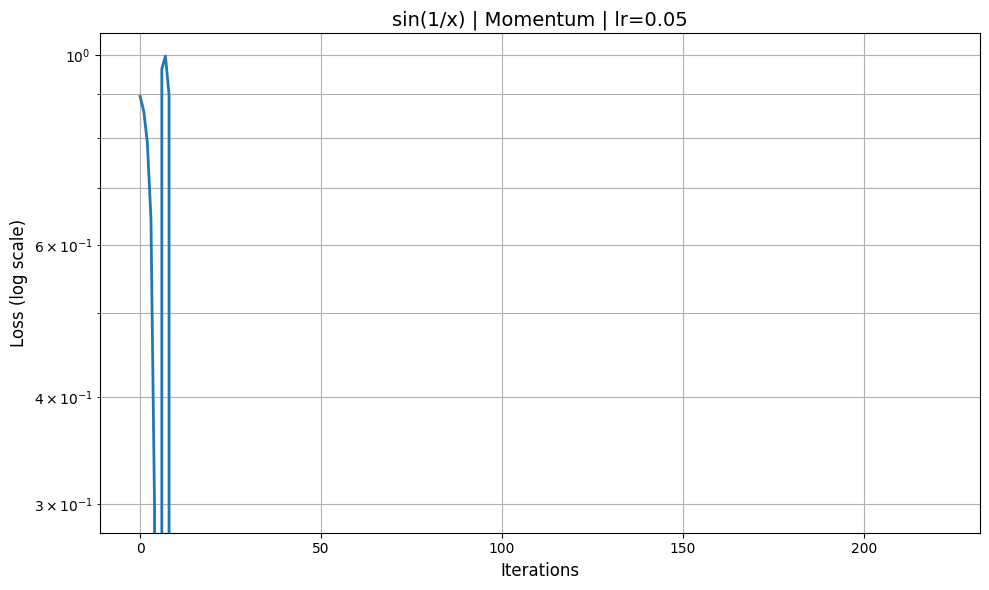

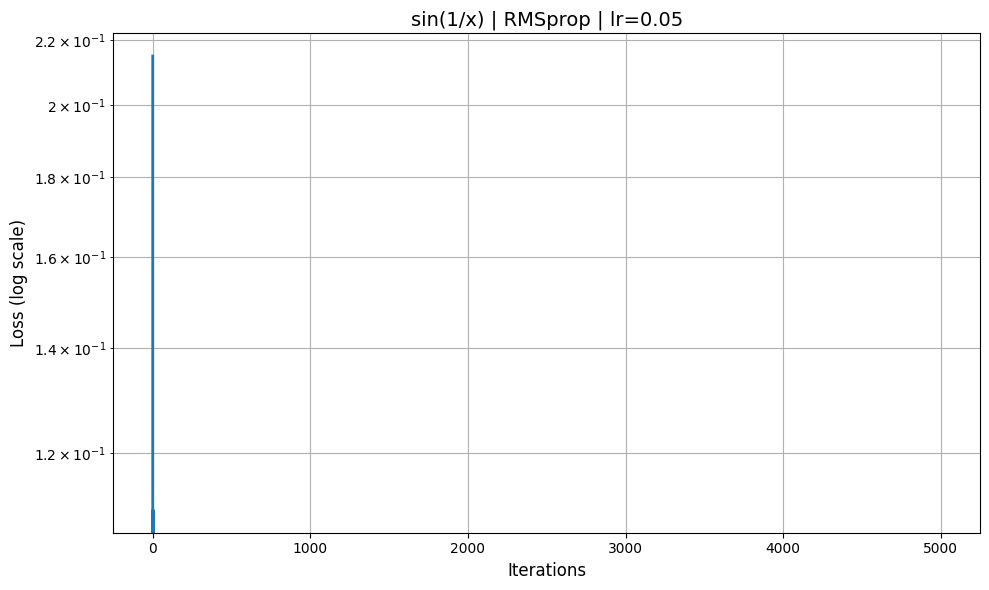

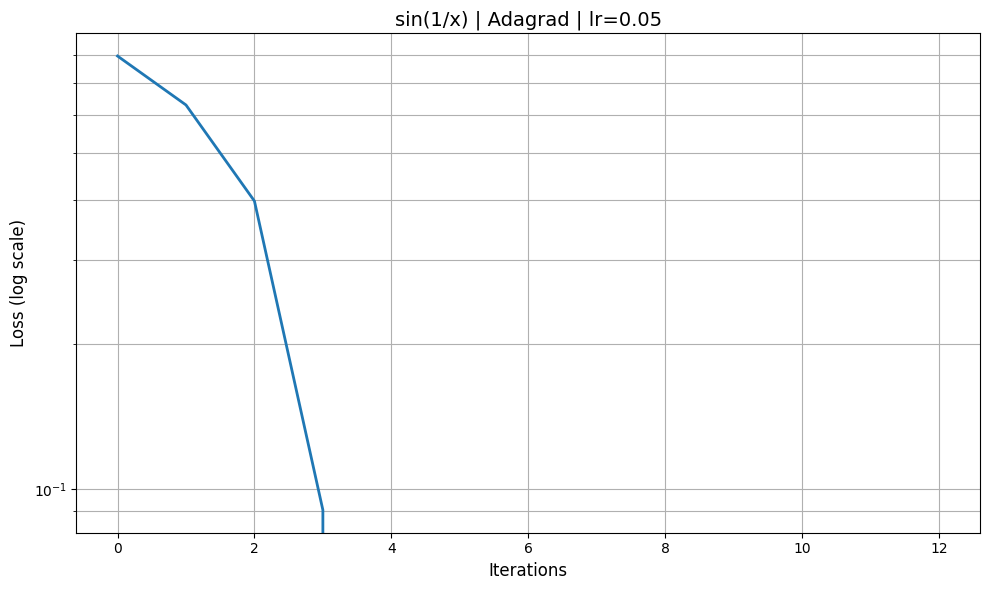

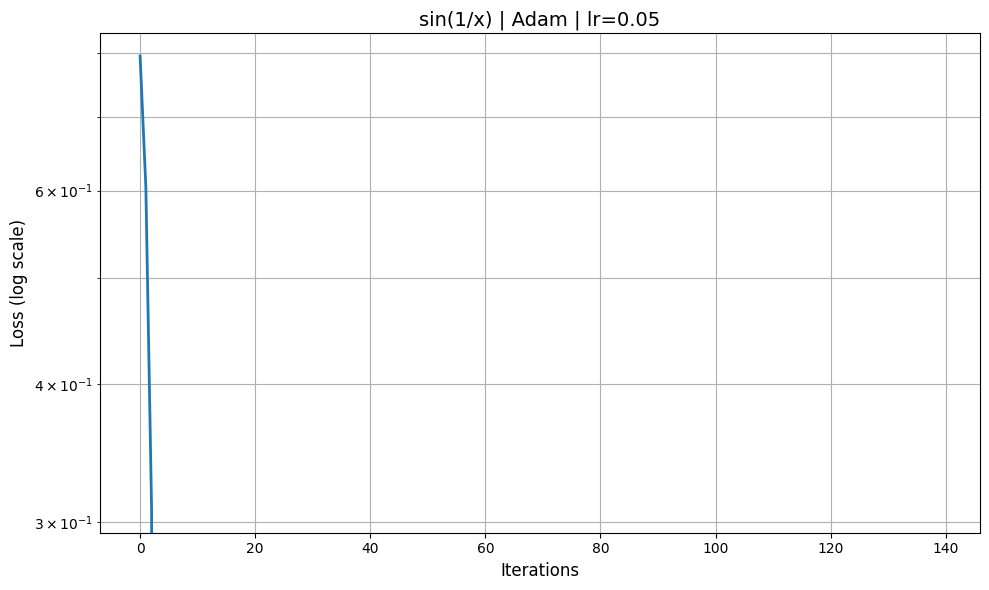

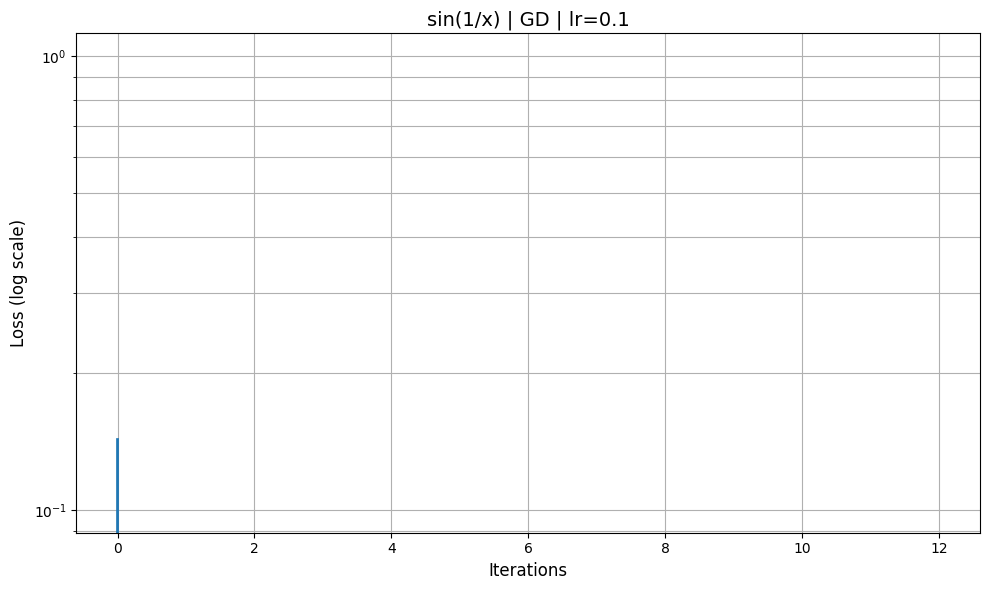

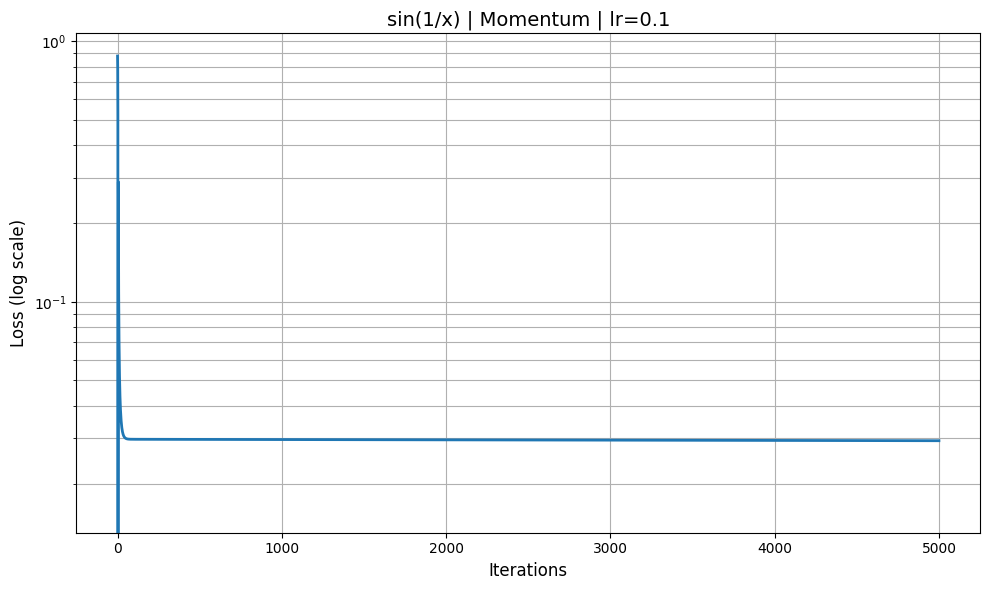

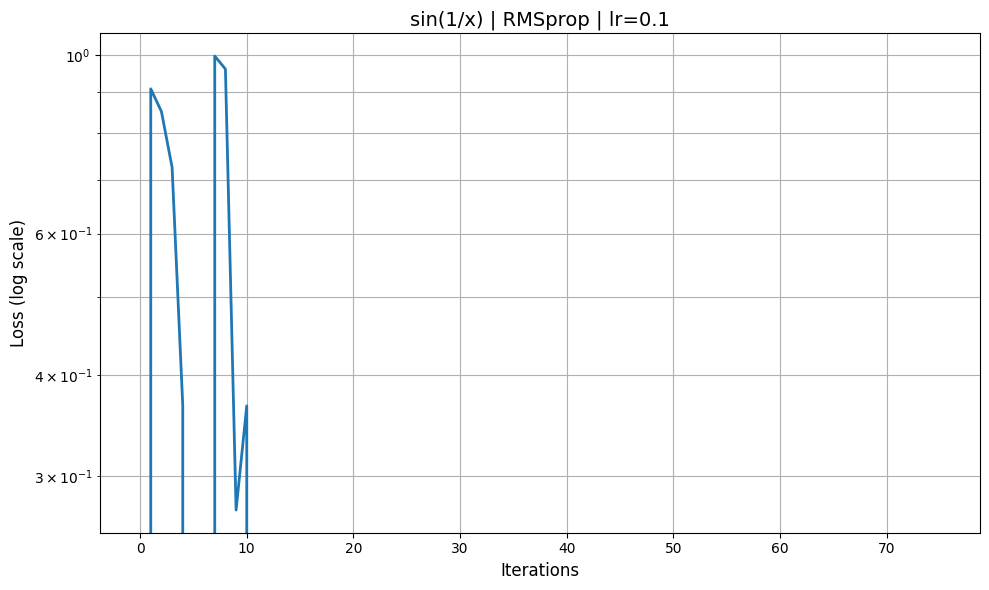

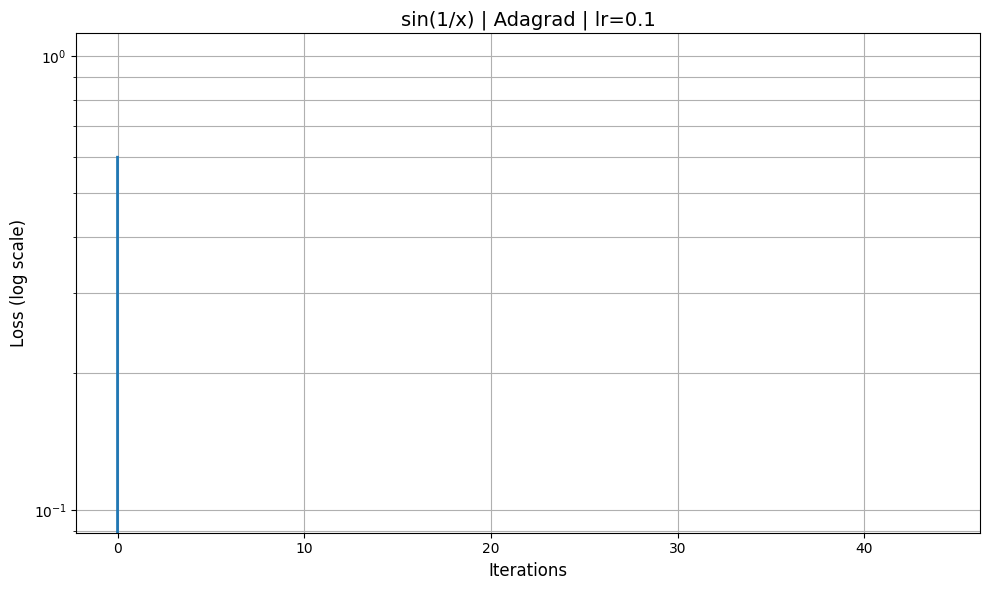

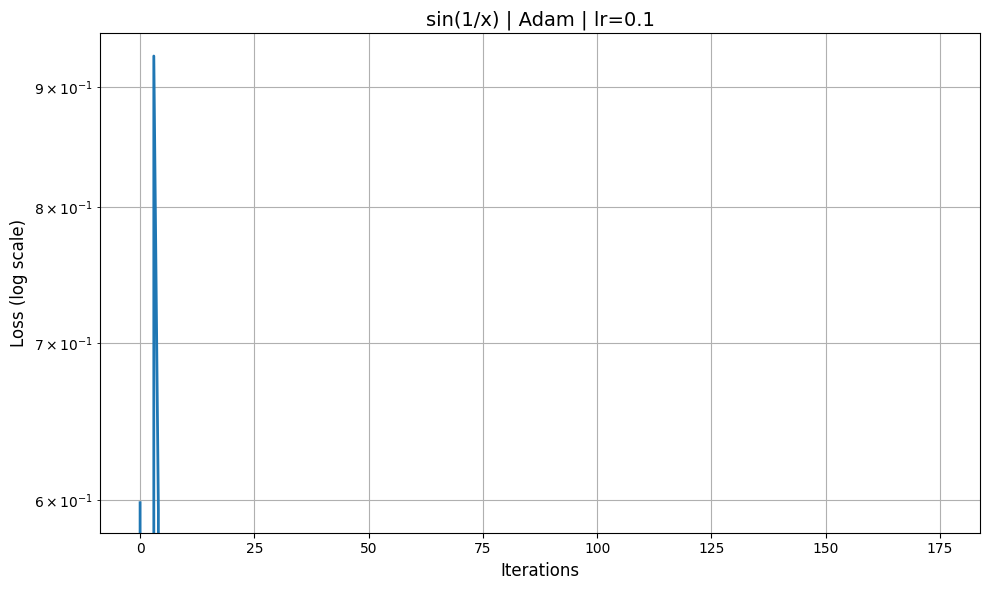

      Function Optimizer    LR                                   Optimal x  \
0   Rosenbrock        GD  0.01                               [13.05, 13.0]   
1   Rosenbrock  Momentum  0.01    [0.9998925343395467, 0.9997846501654034]   
2   Rosenbrock   RMSprop  0.01    [0.9888258679600038, 0.9629335778322273]   
3   Rosenbrock   Adagrad  0.01   [-1.2751471254235613, 1.6321692033546886]   
4   Rosenbrock      Adam  0.01    [0.9934905913943894, 0.9870047070804427]   
5   Rosenbrock        GD  0.05                              [71.25, 459.0]   
6   Rosenbrock  Momentum  0.05    [-17.75009523667409, 438.92706492103997]   
7   Rosenbrock   RMSprop  0.05   [0.7249997721533049, 0.46562467932315355]   
8   Rosenbrock   Adagrad  0.05   [-0.7396136292224176, 0.5521589670177519]   
9   Rosenbrock      Adam  0.05    [0.9999373516382042, 0.9998745208821711]   
10  Rosenbrock        GD  0.10                           [-56.0, 499916.5]   
11  Rosenbrock  Momentum  0.10      [55.20889940396523, 962.4941

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

np.random.seed(42)

# =========================================================
# NON-CONVEX FUNCTIONS (NUMERICALLY SAFE)
# =========================================================

def rosenbrock(x, y):
    x = np.clip(x, -1e3, 1e3)
    y = np.clip(y, -1e3, 1e3)
    return (1 - x)**2 + 100 * (y - x**2)**2

def rosenbrock_grad(x, y):
    x = np.clip(x, -1e3, 1e3)
    y = np.clip(y, -1e3, 1e3)
    dx = -2*(1 - x) - 400*x*(y - x**2)
    dy = 200*(y - x**2)
    grad = np.array([dx, dy])
    return np.clip(grad, -1e3, 1e3)

def sin_inverse(x):
    if abs(x) < 1e-6:
        return 0.0
    return np.sin(1/x)

def sin_inverse_grad(x):
    if abs(x) < 1e-6:
        return 0.0
    return -np.cos(1/x) / (x**2)

# =========================================================
# OPTIMIZERS
# =========================================================

class GradientDescent:
    def __init__(self, lr): self.lr = lr
    def step(self, x, g): return x - self.lr * g

class Momentum:
    def __init__(self, lr, beta=0.9):
        self.lr, self.beta, self.v = lr, beta, None
    def step(self, x, g):
        if self.v is None: self.v = np.zeros_like(x)
        self.v = self.beta*self.v + (1-self.beta)*g
        return x - self.lr*self.v

class RMSprop:
    def __init__(self, lr, beta=0.9, eps=1e-8):
        self.lr, self.beta, self.eps, self.s = lr, beta, eps, None
    def step(self, x, g):
        if self.s is None: self.s = np.zeros_like(x)
        self.s = self.beta*self.s + (1-self.beta)*g**2
        return x - self.lr*g/(np.sqrt(self.s)+self.eps)

class Adagrad:
    def __init__(self, lr, eps=1e-8):
        self.lr, self.eps, self.G = lr, eps, None
    def step(self, x, g):
        if self.G is None: self.G = np.zeros_like(x)
        self.G += g**2
        return x - self.lr*g/(np.sqrt(self.G)+self.eps)

class Adam:
    def __init__(self, lr, b1=0.9, b2=0.999, eps=1e-8):
        self.lr, self.b1, self.b2, self.eps = lr, b1, b2, eps
        self.m, self.v, self.t = None, None, 0
    def step(self, x, g):
        if self.m is None:
            self.m, self.v = np.zeros_like(x), np.zeros_like(x)
        self.t += 1
        self.m = self.b1*self.m + (1-self.b1)*g
        self.v = self.b2*self.v + (1-self.b2)*(g**2)
        mh = self.m/(1-self.b1**self.t)
        vh = self.v/(1-self.b2**self.t)
        return x - self.lr*mh/(np.sqrt(vh)+self.eps)

# =========================================================
# OPTIMIZATION RUNNER
# =========================================================

def optimize(f, g, opt, x0, max_it=5000, tol=1e-6):
    x, hist = x0, []
    t0 = time.time()
    for _ in range(max_it):
        grad = g(*x) if isinstance(x, np.ndarray) else g(x)
        if not np.all(np.isfinite(grad)): break
        xn = opt.step(x, grad)
        if not np.all(np.isfinite(xn)): break
        loss = f(*xn) if isinstance(xn, np.ndarray) else f(xn)
        if not np.isfinite(loss): break
        hist.append(loss)
        if np.linalg.norm(xn-x) < tol: break
        x = xn
    return x, hist, time.time()-t0

# =========================================================
# EXPERIMENTS (MAX CLARITY PLOTS)
# =========================================================

lrs = [0.01, 0.05, 0.1]
opts = {
    "GD": GradientDescent,
    "Momentum": Momentum,
    "RMSprop": RMSprop,
    "Adagrad": Adagrad,
    "Adam": Adam
}

results = []

def plot_clear(history, title):
    plt.figure(figsize=(10,6))
    plt.plot(history, linewidth=2)
    plt.yscale("log")
    plt.xlabel("Iterations", fontsize=12)
    plt.ylabel("Loss (log scale)", fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, which="both")
    plt.tight_layout()
    plt.show()

# Rosenbrock
for lr in lrs:
    for name, O in opts.items():
        x, h, t = optimize(rosenbrock, rosenbrock_grad, O(lr), np.array([-1.5,1.5]))
        results.append(["Rosenbrock", name, lr, x, rosenbrock(*x), len(h), t])
        plot_clear(h, f"Rosenbrock | {name} | lr={lr}")

# sin(1/x)
for lr in lrs:
    for name, O in opts.items():
        x, h, t = optimize(sin_inverse, sin_inverse_grad, O(lr), 0.5)
        results.append(["sin(1/x)", name, lr, x, sin_inverse(x), len(h), t])
        plot_clear(h, f"sin(1/x) | {name} | lr={lr}")

# =========================================================
# RESULTS TABLE
# =========================================================

df = pd.DataFrame(results, columns=[
    "Function","Optimizer","LR","Optimal x","Final f(x)","Iterations","Time(s)"
])

print(df)